In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import timeit

from numpy import genfromtxt

from sklearn.model_selection import LeaveOneOut

from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn.naive_bayes import GaussianNB

### From the test_acc.csv (edited from the results obtained from timeseriesclassification.com) and the features extracted from the training datasets using tsfresh (use the run_pre_tsfresh.sh to obtain it), we organize the meta-data in this section.

In [2]:
test_acc = pd.read_csv('test_acc.csv')
test_acc.head()

,TESTACC,ROCKET,ResNet,WEASEL,BOSS,S-BOSS,ProximityForest,InceptionTime,TS-CHIEF,STC,HIVE-COTE v1.0
0,ACSF1,0.807000,0.824000,0.818000,0.768333,0.815000,0.638333,0.826667,0.807000,0.838333,0.850000
1,Adiac,0.771952,0.815431,0.798806,0.749020,0.742711,0.722165,0.822080,0.779710,0.793180,0.796249
2,ArrowHead,0.859048,0.858667,0.848381,0.868762,0.887810,0.883619,0.880381,0.881143,0.806667,0.876000
3,Beef,0.760000,0.676667,0.740000,0.612222,0.655556,0.594444,0.682222,0.632222,0.735556,0.735556
4,BeetleFly,0.885000,0.853333,0.886667,0.943333,0.936667,0.860000,0.893333,0.958333,0.933333,0.963333


In [3]:
ds_metafeatures = np.empty([test_acc.shape[0],2])

i = 0;
for data_name in test_acc["TESTACC"]:
    file_path = "./data/" + data_name + "/" + data_name + "_TRAIN.tsv"
    data = genfromtxt(file_path, delimiter='\t')
    ds_metafeatures[i][0] = data.shape[0]
    ds_metafeatures[i][1] = len(np.unique(data[:,0]))
    i += 1

In [4]:
y = np.array(test_acc.drop('TESTACC',axis=1)).argmax(axis=1)+1 # meta-targets

In [5]:
this_feature_set = pd.read_csv('tsfresh/' + test_acc['TESTACC'][0] + '_TRAIN.csv').drop(labels=["Unnamed: 0"],axis=1)
this_feature_set = np.hstack([this_feature_set.mean(axis=0),this_feature_set.std(axis=0),
                     ds_metafeatures[0,0],ds_metafeatures[0,1]])

X = np.empty([test_acc.shape[0],this_feature_set.shape[0]])
X[0] = this_feature_set

for i in range(1,len(y)):
    
    dataset = test_acc['TESTACC'][i]
    print(dataset)
    
    this_feature_set = pd.read_csv('tsfresh/' + dataset + '_TRAIN.csv').drop(labels=["Unnamed: 0"],axis=1)
    X[i] = np.hstack([this_feature_set.mean(axis=0),this_feature_set.std(axis=0),
                     ds_metafeatures[i,0],ds_metafeatures[i,1]])

Adiac
ArrowHead
Beef
BeetleFly
BirdChicken
BME
Car
CBF
Chinatown
ChlorineConcentration
CinCECGTorso
Coffee
Computers
CricketX
CricketY
CricketZ
Crop
DiatomSizeReduction
DistalPhalanxOutlineAgeGroup
DistalPhalanxOutlineCorrect
DistalPhalanxTW
Earthquakes
ECG200
ECG5000
ECGFiveDays
ElectricDevices
EOGHorizontalSignal
EOGVerticalSignal
EthanolLevel
FaceAll
FaceFour
FacesUCR
FiftyWords
Fish
FordA
FreezerRegularTrain
FreezerSmallTrain
GunPoint
GunPointAgeSpan
GunPointMaleVersusFemale
GunPointOldVersusYoung
Ham
Haptics
Herring
HouseTwenty
InlineSkate
InsectEPGRegularTrain
InsectEPGSmallTrain
InsectWingbeatSound
ItalyPowerDemand
LargeKitchenAppliances
Lightning2
Lightning7
Mallat
Meat
MedicalImages
MiddlePhalanxOutlineAgeGroup
MiddlePhalanxOutlineCorrect
MiddlePhalanxTW
MixedShapesRegularTrain
MixedShapesSmallTrain
MoteStrain
OliveOil
OSULeaf
PhalangesOutlinesCorrect
Phoneme
PigAirwayPressure
PigArtPressure
PigCVP
Plane
PowerCons
ProximalPhalanxOutlineAgeGroup
ProximalPhalanxOutlineCorrect
Pr

In [6]:
for i in range(X.shape[1]):
    print(np.std(X[:,i]))

152133.28465155655
111.25358332253097
136.46782097981787
561.624196031997
94.47168842822842
69942.33733903148
166.0271830874618
456.34087322686355
79.77157745851436
8887.700616641092
5.688140287194841
5.68477222423102
561.624196031997
0.2750220036310431
0.2736854715364625
5.618765472686843
5.588928066523034
5.857066578162277
43161.995692799224
50.123188517685634
51.06032702607718
0.0
20.553140531917215
26757.629945552464
52.67942088362869
342.5161633573871
43.407648148685425
5058.752715405807
3.397893625133619
3.405485541291905
0.0
6.729880642467274e-10
1.3317969504141668e-09
3.420877466709632
3.3852863697216757
3.391241294175075
1137.3290463798808
11.733406986300816


In [7]:
X = np.delete(X, np.where(np.std(X, axis=0) < 10e-5), axis = 1) # remove meta-attributes with low stdev

In [8]:
np.savetxt("meta-attributes.csv", X, delimiter=",")
np.savetxt("meta-targets.csv", y, delimiter=",")

### Start here if you already have extracted the meta-knowledge. 

In [9]:
# X = genfromtxt('meta-attributes.csv', delimiter=',')
# y = genfromtxt('meta-targets.csv', delimiter=',')

df = pd.DataFrame(X)
X = df.replace([np.inf, -np.inf], np.nan).dropna(axis=1).to_numpy() #cleaning

#### Defining useful methods

In [10]:
def show_results(preds):
    
    test_acc = pd.read_csv('test_acc.csv')
    topline = np.array(test_acc.drop('TESTACC',axis=1)).max(axis=1)
    baseline = np.array(test_acc.drop('TESTACC',axis=1)).mean(axis=1)
    
    accs_meta = []
    for i in range(len(preds)):
        accs_meta.append(test_acc.iloc[i][int(preds[i])])
        
    sota = test_acc['ROCKET']
    
    print('Mean Acc (std):')
    
    print('Topline: ' + "{:.4f}".format(np.mean(topline)) +
         '(' + "{:.4f}".format(np.std(topline)) + ')' + 
         ' - Median =' + "{:.4f}".format(np.median(topline)))
    
    print('MetaL: ' + "{:.4f}".format(np.mean(accs_meta)) +
         '(' + "{:.4f}".format(np.std(accs_meta)) + ')' + 
         ' - Median =' + "{:.4f}".format(np.median(accs_meta)))
    
    print('ROCKET: ' + "{:.4f}".format(np.mean(sota)) +
         '(' + "{:.4f}".format(np.std(sota)) + ')' + 
         ' - Median =' + "{:.4f}".format(np.median(sota)))
    
    print(' ')
    
    print('MetaL vs ROCKET')
    print('MetaL Wins:' + str(np.sum(accs_meta > sota)))
    print('MetaL Loses:' + str(np.sum(accs_meta < sota)))
    print('Draws:' + str(np.sum(accs_meta == sota)))
    
    print(' ')
    
    print('MetaL vs topline')
    print('MetaL Wins:' + str(np.sum(accs_meta > topline)))
    print('MetaL Loses:' + str(np.sum(accs_meta < topline)))
    print('Draws:' + str(np.sum(accs_meta == topline)))
    
    print(' ')
    
    print('MetaL vs baseline')
    print('MetaL Wins:' + str(np.sum(accs_meta > baseline)))
    print('MetaL Loses:' + str(np.sum(accs_meta < baseline)))
    print('Draws:' + str(np.sum(accs_meta == baseline)))

In [11]:
def run_metamodel(option='random_forest', random_state=42):
    
    preds = []
    
    loo = LeaveOneOut()
    loo.get_n_splits(X)
    
    total_time = 0
    
    for train_index, test_index in loo.split(X):
        
        # print("TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if (option=='1nn'):
            model = neighbors.KNeighborsClassifier(1)
        elif (option=='5nn'):
            model = neighbors.KNeighborsClassifier()
        elif (option=='svm'):
            model = svm.SVC()
        elif (option=='gbc'):
            model = GradientBoostingClassifier(random_state=random_state)
        elif (option=='nb'):
            model = GaussianNB()
        else:
            model = RandomForestClassifier(random_state=random_state)
            
        start = timeit.default_timer()
        model.fit(X_train, y_train)
        stop = timeit.default_timer()
        total_time += stop - start
        
        y_hat = model.predict(X_test)
        preds.append(y_hat)
    
    print('LOO runtime (seconds): ', total_time)
    
    return preds

#### Runing/training the metamodels

In [12]:
rf = []
rf_fs = []


print('MetaL-CATS-1NN')
nn = run_metamodel(option='1nn')

print('MetaL-CATS-5NN')
knn = run_metamodel(option='5nn')

print('MetaL-CATS-SVM')
svc = run_metamodel(option='svc')

print('MetaL-CATS-NB')
nb = run_metamodel(option='nb')


print('MetaL-CATS-RF (10 runs)')
for i in range(10):
    print('RF: Random seed = ' + str(i))
    rf.append(run_metamodel(option='random_forest', random_state=i))

MetaL-CATS-1NN
LOO runtime (seconds):  0.017649985995376483
MetaL-CATS-5NN
LOO runtime (seconds):  0.01678123400779441
MetaL-CATS-SVM
LOO runtime (seconds):  10.28770264598279
MetaL-CATS-NB
LOO runtime (seconds):  0.08937276396318339
MetaL-CATS-RF (10 runs)
RF: Random seed = 0
LOO runtime (seconds):  11.408781083002395
RF: Random seed = 1
LOO runtime (seconds):  10.969846754982427
RF: Random seed = 2
LOO runtime (seconds):  11.472129324007255
RF: Random seed = 3
LOO runtime (seconds):  10.163225032985792
RF: Random seed = 4
LOO runtime (seconds):  10.373157451002044
RF: Random seed = 5
LOO runtime (seconds):  10.306925653931103
RF: Random seed = 6
LOO runtime (seconds):  10.101892440005031
RF: Random seed = 7
LOO runtime (seconds):  9.760554398009845
RF: Random seed = 8
LOO runtime (seconds):  9.799594435986364
RF: Random seed = 9
LOO runtime (seconds):  10.722339906969864


In [13]:
'''
run it if you are interested in saving the results
'''
np.save('rf.npy',rf)
np.save('nn.npy',nn)
np.save('knn.npy',knn)
np.save('rsvc.npy',svc)
np.save('nb.npy',nb)

In [14]:
'''
run it if you are interested in strating from the saved results
'''
# np.save('rf.npy',rf)
# np.save('nn.npy',nn)
# np.save('knn.npy',knn)
# np.save('svc.npy',svc)
# np.save('nb.npy',nb)

'\nrun it if you are interested in strating from the saved results\n'

In [15]:
print('------------\n1-nn\n')
show_results(nn)
print('------------\n5-nn\n')
show_results(knn)
print('------------\nGaussian NB\n')
show_results(nb)
print('------------\nSVM\n')
show_results(svc)
print('------------\nRF (seed=0)\n')
show_results(rf[0])
print('------------')

------------
1-nn

Mean Acc (std):
Topline: 0.8986(0.1129) - Median =0.9479
MetaL: 0.8649(0.1465) - Median =0.9014
ROCKET: 0.8640(0.1442) - Median =0.9070
 
MetaL vs ROCKET
MetaL Wins:45
MetaL Loses:39
Draws:24
 
MetaL vs topline
MetaL Wins:0
MetaL Loses:81
Draws:27
 
MetaL vs baseline
MetaL Wins:86
MetaL Loses:21
Draws:1
------------
5-nn

Mean Acc (std):
Topline: 0.8986(0.1129) - Median =0.9479
MetaL: 0.8717(0.1310) - Median =0.9084
ROCKET: 0.8640(0.1442) - Median =0.9070
 
MetaL vs ROCKET
MetaL Wins:35
MetaL Loses:30
Draws:43
 
MetaL vs topline
MetaL Wins:0
MetaL Loses:78
Draws:30
 
MetaL vs baseline
MetaL Wins:87
MetaL Loses:20
Draws:1
------------
Gaussian NB

Mean Acc (std):
Topline: 0.8986(0.1129) - Median =0.9479
MetaL: 0.8612(0.1374) - Median =0.8987
ROCKET: 0.8640(0.1442) - Median =0.9070
 
MetaL vs ROCKET
MetaL Wins:32
MetaL Loses:73
Draws:3
 
MetaL vs topline
MetaL Wins:0
MetaL Loses:102
Draws:6
 
MetaL vs baseline
MetaL Wins:64
MetaL Loses:43
Draws:1
------------
SVM

Mean

#### Comparative and ploting routines

In [16]:
topline = np.array(test_acc.drop('TESTACC',axis=1)).max(axis=1)
baseline = np.array(test_acc.drop('TESTACC',axis=1)).mean(axis=1)
worstcase = np.array(test_acc.drop('TESTACC',axis=1)).min(axis=1)

ts_chief = test_acc['TS-CHIEF']
hive_cote = test_acc['HIVE-COTE v1.0']
rocket = test_acc['ROCKET']

def get_accs(preds):
    accs_meta = []
    for i in range(len(preds)):
        accs_meta.append(test_acc.iloc[i][int(preds[i])])
        
    return accs_meta

In [17]:
# to a better evaluation of RF
rf_avg = np.zeros(108)
for i in range(10):
    rf_avg += get_accs(rf[i])
rf_avg /= 10

print(np.mean(rf_avg))
print(np.std(rf_avg))
print(np.median(rf_avg))
print('TS-CHIEF vs MetaL-RF')
print('Wins:' + str(np.sum(ts_chief > rf_avg)))
print('Loses:' + str(np.sum(ts_chief < rf_avg)))
print('Draws:' + str(np.sum(ts_chief == rf_avg)))

0.8758346960345719
0.1290165599040079
0.9154320987654314
TS-CHIEF vs MetaL-RF
Wins:47
Loses:51
Draws:10


In [18]:
dicio = {"Accuracy" : np.hstack((baseline, get_accs(nn), 
                                 get_accs(knn), get_accs(nb),
                                 rf_avg,get_accs(svc),
                                 ts_chief,topline)).T,
        "Algorithm" : np.hstack((
                        ["Baseline"]*len(topline),
                        ["MetaL-CATS-1NN"]*len(topline), 
                        ["MetaL-CATS-5NN"]*len(topline), 
                        ["MetaL-CATS-NB"]*len(topline),
                        ["MetaL-CATS-RF"]*len(topline), 
                        ["MetaL-CATS-SVM"]*len(topline), 
                        ["TS-CHIEF"]*len(topline),
                        ["Topline"]*len(topline)
                                )).T}

results = pd.DataFrame(dicio)

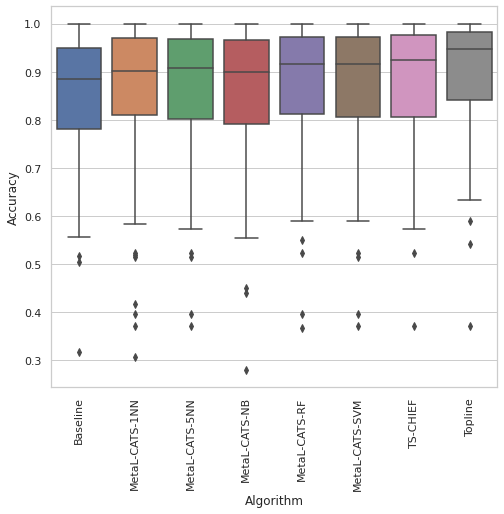

In [19]:
f = plt.figure(figsize=[8,7])
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="Algorithm", y="Accuracy", data=results)
plt.xticks(rotation=90)
f.savefig("boxplot.pdf")

In [20]:
dicio = {"Accuracy" : np.hstack((baseline, get_accs(nn), 
                                 get_accs(knn), get_accs(nb),
                                 rf_avg,get_accs(svc),
                                 ts_chief,topline)).T,
        "Algorithm" : np.hstack((
                        ["Baseline"]*len(topline),
                        ["MetaL-CATS-1NN"]*len(topline), 
                        ["MetaL-CATS-5NN"]*len(topline), 
                        ["MetaL-CATS-NB"]*len(topline),
                        ["MetaL-CATS-RF"]*len(topline), 
                        ["MetaL-CATS-SVM"]*len(topline), 
                        ["ROCKET"]*len(topline),
                        ["Topline"]*len(topline)
                                )).T}

results = pd.DataFrame(dicio)

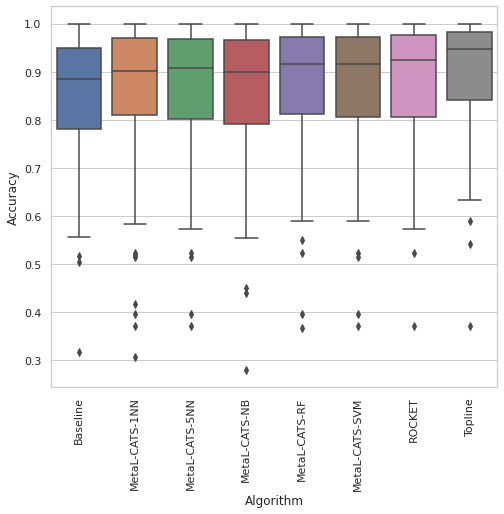

In [21]:
f = plt.figure(figsize=[8,7])
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="Algorithm", y="Accuracy", data=results)
plt.xticks(rotation=90)
f.savefig("boxplot_rocket.pdf")

In [22]:
# TS-CHIEF vs HIVE-COTE
print(hive_cote.mean())
print(ts_chief.mean())

print('TS-CHIEF vs HIVE-COTE')
print('TS-CHIEF Wins:' + str(np.sum(ts_chief > hive_cote)))
print('Loses:' + str(np.sum(ts_chief < hive_cote)))
print('Draws:' + str(np.sum(ts_chief == hive_cote)))

0.8781735034390735
0.8757283866749672
TS-CHIEF vs HIVE-COTE
TS-CHIEF Wins:53
Loses:49
Draws:6


In [23]:
# ROCKET vs HIVE-COTE
print(hive_cote.mean())
print(rocket.mean())

print('ROCKET vs HIVE-COTE')
print('ROCKET Wins:' + str(np.sum(rocket > hive_cote)))
print('Loses:' + str(np.sum(rocket < hive_cote)))
print('Draws:' + str(np.sum(rocket == hive_cote)))

0.8781735034390735
0.8639965815485325
ROCKET vs HIVE-COTE
ROCKET Wins:57
Loses:48
Draws:3


In [24]:
svc_acc = get_accs(svc)
print(np.mean(svc_acc))
print(hive_cote.mean())
print('TS-CHIEF vs MetaL-SVM')
print('TS-CHIEF Wins:' + str(np.sum(ts_chief > svc_acc)))
print('TS-CHIEFLoses:' + str(np.sum(ts_chief < svc_acc)))
print('Draws:' + str(np.sum(ts_chief == svc_acc)))

0.8741007041736609
0.8781735034390735
TS-CHIEF vs MetaL-SVM
TS-CHIEF Wins:31
TS-CHIEFLoses:40
Draws:37


In [25]:
svc_acc = get_accs(svc)
print(np.mean(svc_acc))
print(rocket.mean())
print('ROCKET vs MetaL-SVM')
print('ROCKET Wins:' + str(np.sum(rocket > svc_acc)))
print('ROCKET Loses:' + str(np.sum(rocket < svc_acc)))
print('Draws:' + str(np.sum(rocket == svc_acc)))

0.8741007041736609
0.8639965815485325
ROCKET vs MetaL-SVM
ROCKET Wins:33
ROCKET Loses:48
Draws:27


In [26]:
accs = test_acc.drop('TESTACC',axis=1)

svc_acc = get_accs(svc)
print('Algorithm\tWins/Losses')

# cada um contra baseline
for  this_alg in accs.keys():
    this_acc = test_acc[this_alg]
    print(this_alg + '\t' + str(np.sum(this_acc > baseline)) + '/' +
        str(np.sum(this_acc < baseline)))
    
print('MetaL-CATS-SVM\t' + str(np.sum(svc_acc > baseline)) + '/' +
        str(np.sum(svc_acc < baseline)))

Algorithm	Wins/Losses
ROCKET	83/24
ResNet	58/49
WEASEL	48/59
BOSS	36/71
S-BOSS	39/68
ProximityForest	54/53
InceptionTime	81/26
TS-CHIEF	87/20
STC	57/50
HIVE-COTE v1.0	94/13
MetaL-CATS-SVM	91/16


<Figure size 720x720 with 0 Axes>

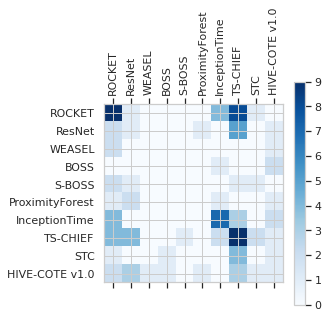

In [27]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(df_confusion, title='Confusion matrix'):
    f = plt.figure(figsize=[10,10])
    plt.matshow(df_confusion, cmap="Blues") # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=90)
    plt.yticks(tick_marks, df_confusion.columns)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    plt.savefig("confusion.pdf")
    
df_confusion = pd.DataFrame(confusion_matrix(y, svc), columns=list(test_acc.keys())[1:])
plot_confusion_matrix(df_confusion)

In [28]:
df_confusion

,ROCKET,ResNet,WEASEL,BOSS,S-BOSS,ProximityForest,InceptionTime,TS-CHIEF,STC,HIVE-COTE v1.0
0,9,1,0,0,0,0,4,8,1,0
1,2,1,0,0,0,1,0,5,0,1
2,2,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1,0,0,2
4,2,1,0,0,0,0,0,1,1,0
5,1,2,0,0,0,0,1,0,0,1
6,4,0,0,0,0,0,7,3,0,2
7,4,4,0,0,1,0,2,9,2,1
8,1,0,0,1,0,0,0,4,0,1
9,2,3,1,1,0,1,0,3,1,1


In [29]:
list(test_acc.keys())[1:-1]

['ROCKET',
 'ResNet',
 'WEASEL',
 'BOSS',
 'S-BOSS',
 'ProximityForest',
 'InceptionTime',
 'TS-CHIEF',
 'STC']

## Hypothesis test

In [30]:
# !pip install Orange3
import Orange 

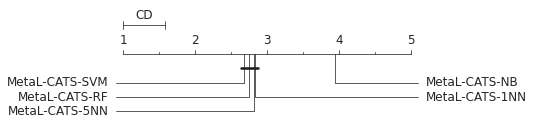

In [34]:
dicio = {"MetaL-CATS-1NN" : get_accs(nn), 
         "MetaL-CATS-5NN" : get_accs(knn),
         "MetaL-CATS-NB" : get_accs(nb),
         "MetaL-CATS-RF" : rf_avg,
         "MetaL-CATS-SVM" : get_accs(svc)}

dicio = pd.DataFrame(dicio)

avranks = dicio.rank(axis=1,ascending=False).mean().values
cd = Orange.evaluation.compute_CD(avranks, dicio.shape[0], 
                                  alpha="0.05", test="nemenyi")

Orange.evaluation.graph_ranks(avranks, dicio.keys(), 
                              cd=cd, width=7, textspace=1.5)
plt.savefig('nemenyi_metalcats.pdf', bbox_inches='tight')
plt.show();

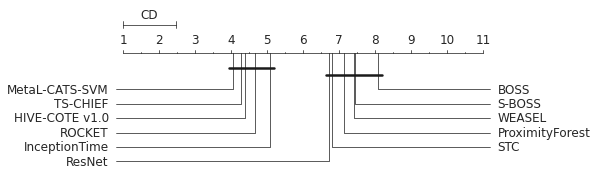

In [32]:
dicio = test_acc.drop('TESTACC',axis=1)
dicio["MetaL-CATS-SVM"] = get_accs(svc)
# dicio["Baseline"] = baseline
# dicio["Topline"] = topline

avranks = dicio.rank(axis=1,ascending=False).mean().values
cd = Orange.evaluation.compute_CD(avranks, dicio.shape[0]-1, 
                                  alpha="0.05", test="nemenyi")

Orange.evaluation.graph_ranks(avranks, dicio.keys(), 
                              cd=cd, width=8, textspace=1.5)
plt.savefig('nemenyi.pdf', bbox_inches='tight')
plt.show();

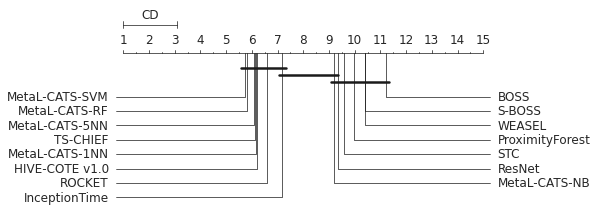

In [33]:
dicio = test_acc.drop('TESTACC',axis=1)
dicio["MetaL-CATS-1NN"] = get_accs(nn)
dicio["MetaL-CATS-5NN"] = get_accs(knn)
dicio["MetaL-CATS-SVM"] = get_accs(svc)
dicio["MetaL-CATS-NB"] = get_accs(nb)
dicio["MetaL-CATS-RF"] = rf_avg

avranks = dicio.rank(axis=1,ascending=False).mean().values
cd = Orange.evaluation.compute_CD(avranks, dicio.shape[0]-1, 
                                  alpha="0.05", test="nemenyi")

Orange.evaluation.graph_ranks(avranks, dicio.keys(), 
                              cd=cd, width=8, textspace=1.5)
plt.savefig('nemenyi.pdf', bbox_inches='tight')
plt.show();